# Scanpy: Data integration

In this tutorial we will look at different ways of integrating multiple single cell RNA-seq datasets. We will explore two different methods to correct for batch effects across datasets. We will also look at a quantitative measure to assess the quality of the integrated data. Seurat uses the data integration method presented in Comprehensive Integration of Single Cell Data, while Scran and Scanpy use a mutual Nearest neighbour method (MNN). Below you can find a list of the most recent methods for single data integration:

Markdown | Language | Library | Ref
--- | --- | --- | ---
CCA | R | Seurat | [Cell](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub)
MNN | R/Python | Scater/Scanpy | [Nat. Biotech.](https://www.nature.com/articles/nbt.4091)
Conos | R | conos | [Nat. Methods](https://www.nature.com/articles/s41592-019-0466-z?error=cookies_not_supported&code=5680289b-6edb-40ad-9934-415dac4fdb2f)
Scanorama | Python | scanorama | [Nat. Biotech.](https://www.nature.com/articles/s41587-019-0113-3)


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

First need to load the QC filtered dataset and create individual adata objects per batch.

In [2]:
# Load the stored data object
save_file = './data/results/scanpy_dr_covid.h5ad'
adata = sc.read_h5ad(save_file)


In [3]:
print(adata.X.shape)

(5594, 3067)


As the stored AnnData object contains scaled data based on variable genes, we need to make a new object with the raw counts and normalized it again. Variable gene selection should not be performed on the scaled data object, only do normalization and log transformation before variable genes selection. 


In [4]:
adata2 = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)



normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Detect variable genes

Variable genes can be detected across the full dataset, but then we run the risk of getting many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. Here, we will do both as an example of how it can be done. 

First we will select genes based on the full dataset.



extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


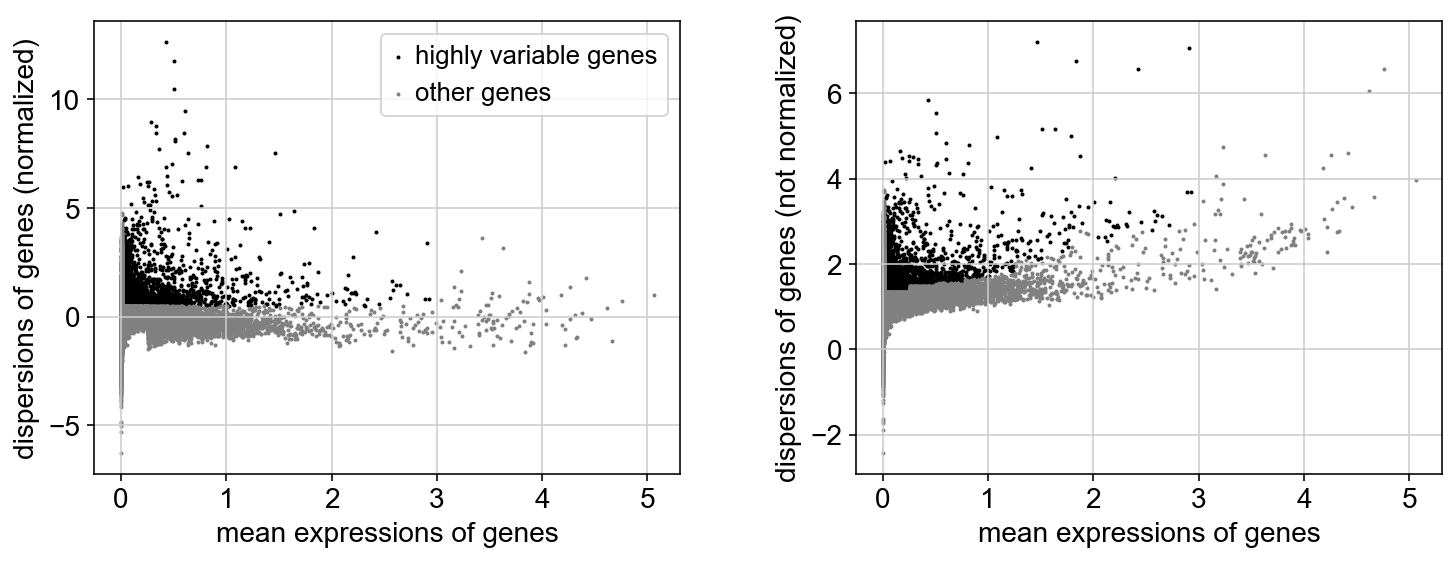

Highly variable genes: 3067


In [5]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata2)

print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

Detect variable genes in each dataset separately using the `batch_key` parameter. 


In [6]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 148
Number of batches where gene is variable:
0    8153
1    4763
2    3116
3    1633
4     697
5     242
6     148
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [7]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Any batch var genes: 10599
All data var genes: 3067
Overlap: 3062
Variable genes in all batches: 148
Overlap batch instersection and all: 146


Select all genes that are variable in at least 2 datasets and use for remaining analysis. 

In [8]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)



2720

### Data integration

First we need to create individual AnnData objects from each of the datasets.

In [9]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

alldata    

{'covid_1': View of AnnData object with n_obs × n_vars = 855 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p', 'hvg',
 'covid_15': View of AnnData object with n_obs × n_vars = 582 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_scor

Then perform batch correction with MNN. 

The function mnn_correct has the following input options:

```    
scanpy.api.pp.mnn_correct(*datas, var_index=None, var_subset=None, 
 batch_key='batch', index_unique='-', batch_categories=None, k=20, 
 sigma=1.0, cos_norm_in=True, cos_norm_out=True, svd_dim=None, 
 var_adj=True, compute_angle=False, mnn_order=None, svd_mode='rsvd', 
 do_concatenate=True, save_raw=False, n_jobs=None, **kwargs)
```

We run it with the option `save_raw=True` so that the uncorrected matrix will be stored in the slot `raw`.

In [10]:
cdata = sc.external.pp.mnn_correct(alldata['covid_1'],alldata['covid_15'],alldata['covid_17'],
                                   alldata['ctrl_5'],alldata['ctrl_13'],alldata['ctrl_14'], 
                                   svd_dim = 50, batch_key = 'sample', save_raw = True, var_subset = var_genes)



/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7fbf1d42e2f0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x7fbf1d42e2f0>)
During: typing of call at /Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/sit

Performing cosine normalization...


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7fbf1d42e2f0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
      With argument(s): '(x=array(float32, 2d, A), axis=int64)':
     Rejected as the implementation raised a specific error:
       TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x7fbf1d42e2f0>)
During: typing of call at /Users/asbj/miniconda3/envs/scRNAseq2021/lib/pyt

Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py (94)

File "../../../../../../../miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../../../../../miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py", line 94:
def

  Computing correction vectors...


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


  Removing components...
  Adjusting variance...
  Applying correction...
Step 2 of 5: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 3 of 5: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 4 of 5: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 5 of 5: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


The mnn_correct function returns a tuple with the AnnData object, list of cell pairs and of angles.Hence, cdata[0] is the new AnnData object. <br> We get corrected expression values for all genes even though only the selected genes were used for finding neighbor cells. For later analysis we want to do dimensionality reduction etc. on the variable genes only, so we will subset the data to only include the variable genes.


In [11]:
corr_data = cdata[0][:,var_genes]
corr_data.X.shape

(5594, 2720)

computing PCA
    with n_comps=50
    finished (0:00:01)


... storing 'type' as categorical
... storing 'batch' as categorical


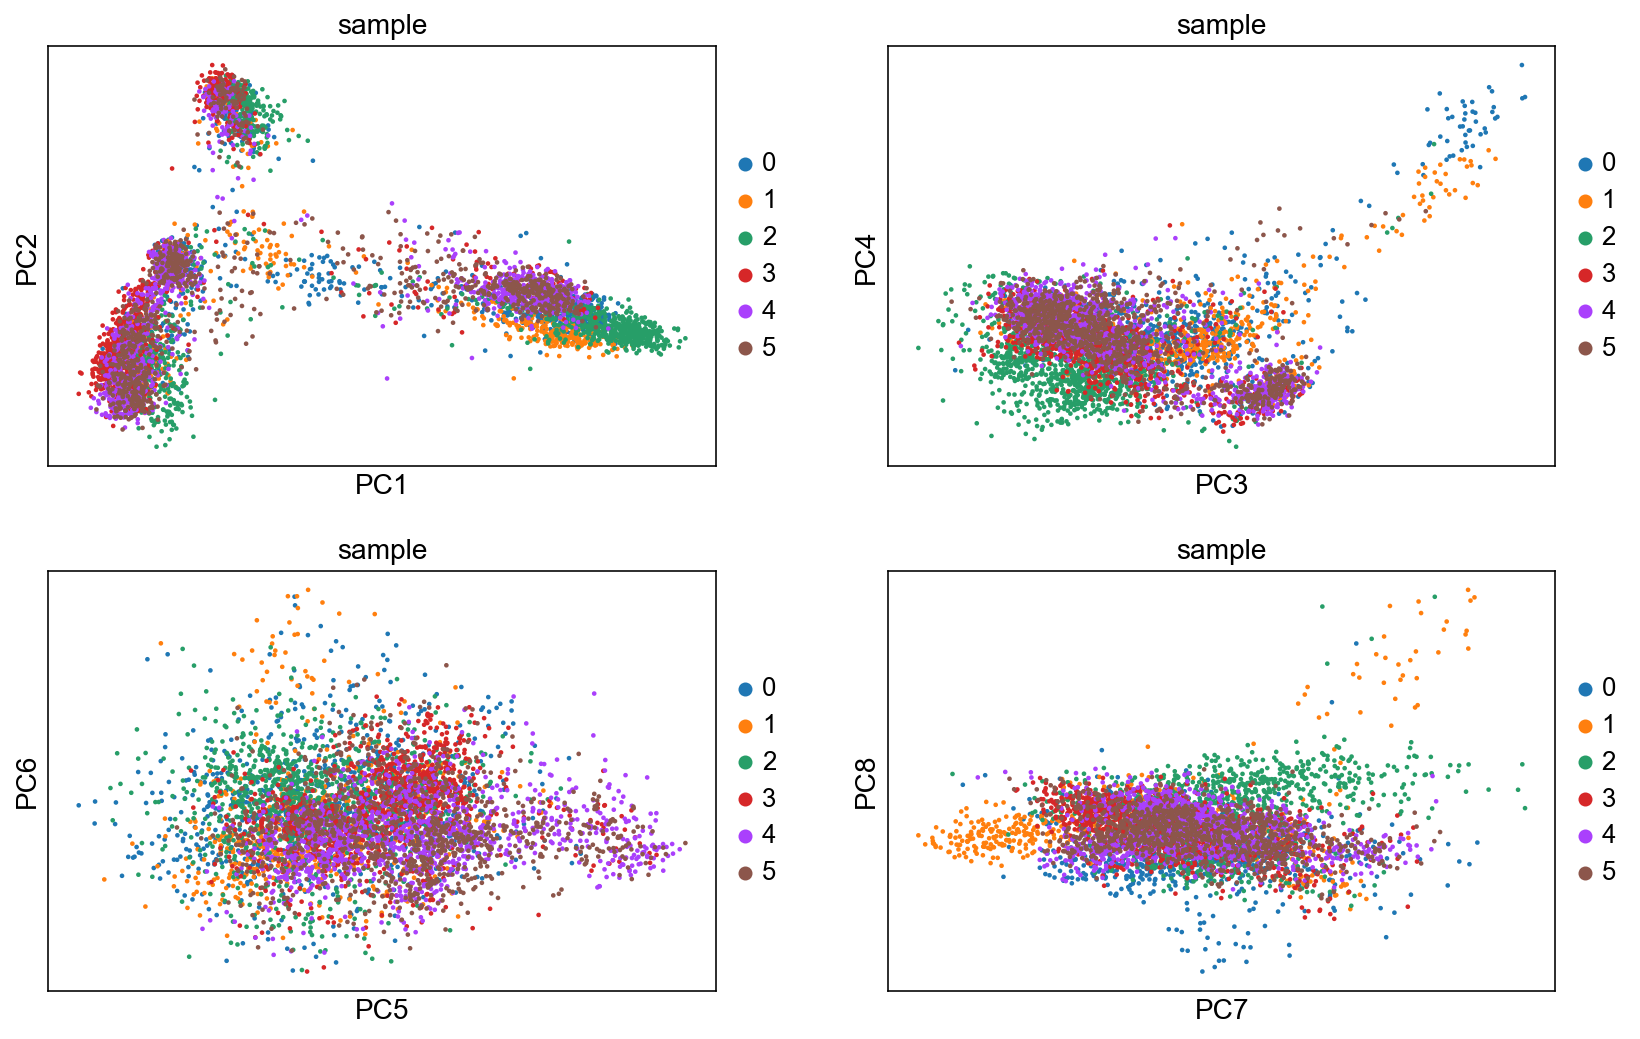

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:37)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [12]:
# the variable genes defined are used by default by the pca function, 
# now we want to run on all the genes in the dataset
sc.tl.pca(corr_data, svd_solver = 'arpack', use_highly_variable = False)
sc.pl.pca(corr_data, components = ['1,2','3,4','5,6','7,8'], ncols=2, color='sample')


# tSNE
sc.tl.tsne(corr_data, n_pcs = 50)
# UMAP, first with neighbor calculation 
sc.pp.neighbors(corr_data, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(corr_data)



We can now plot the un-integrated and the integrated space reduced dimensions.


<AxesSubplot:title={'center':'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

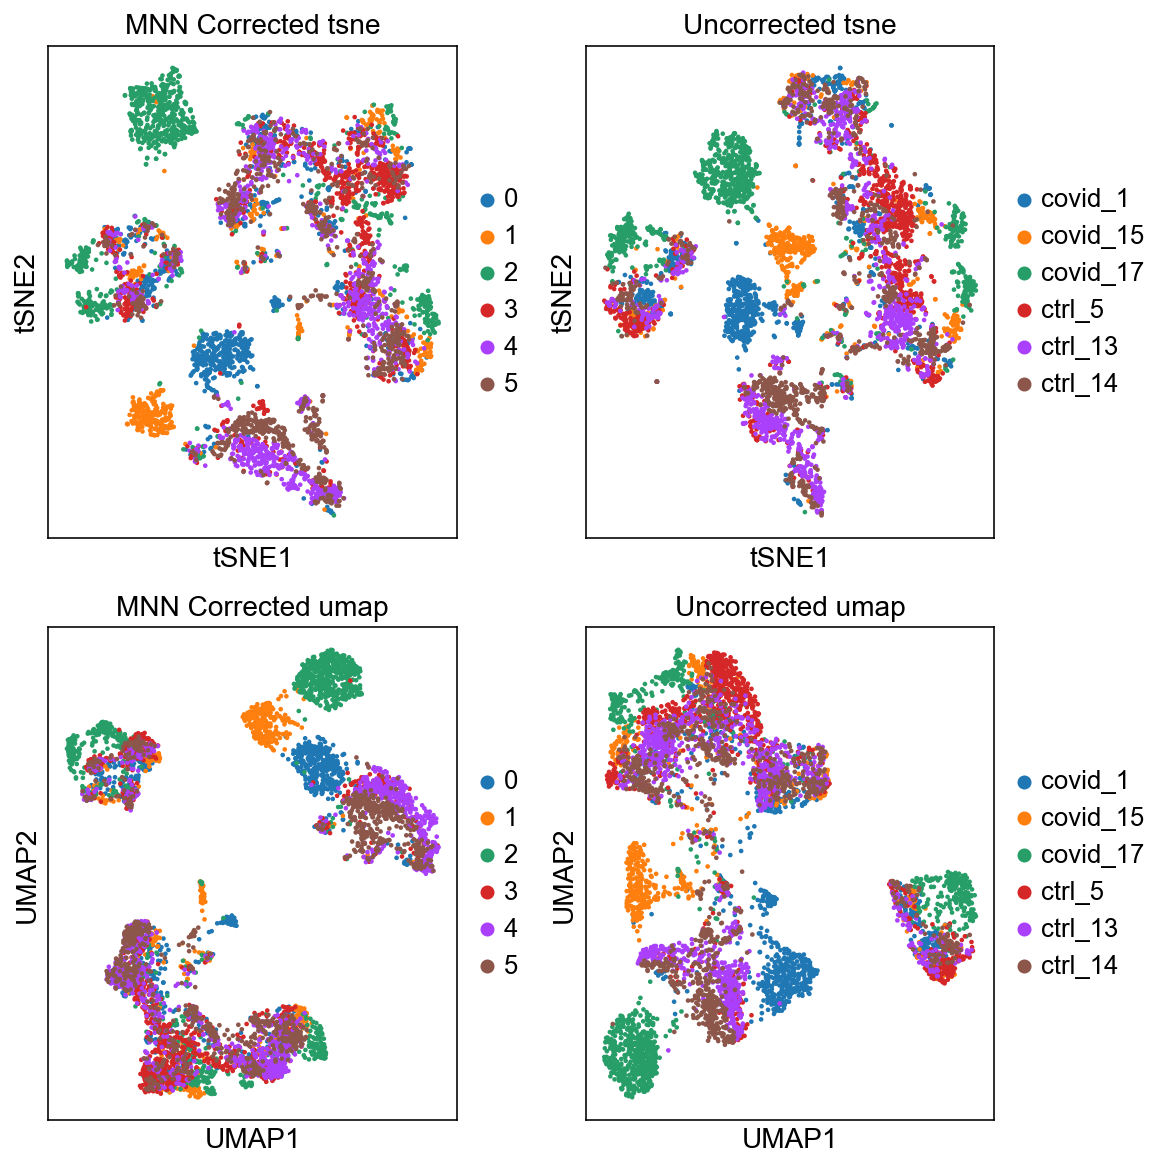

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="sample", title="MNN Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="sample", title="MNN Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1,1], show=False)


Finally, lets save the integrated data for further analysis.


In [14]:
save_file = './data/results/scanpy_mnn_corrected_covid.h5ad'
corr_data.write_h5ad(save_file)

##Extra exercises
###Combat

Batch correction can also be performed with combat.<br>Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).


In [15]:
# create a new object with raw counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

#normalize and log-transform
sc.pp.normalize_per_cell(adata_combat, counts_per_cell_after=1e4)
sc.pp.log1p(adata_combat)

# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='sample')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Found 24 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3904


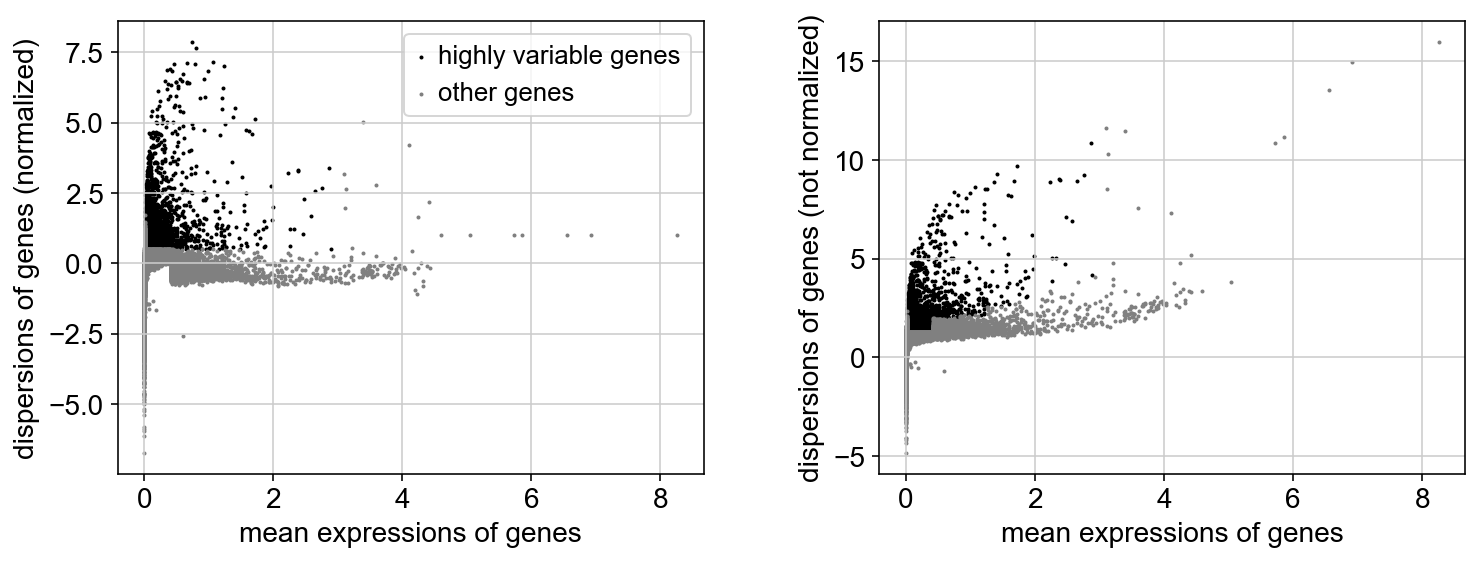

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:35)


In [16]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)


sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat, n_pcs =30)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat, n_pcs = 30)


In [17]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 3067
With combat 3904
Overlap 2268
With 2 batches 2720
Overlap 2037


<AxesSubplot:title={'center':'Combat umap'}, xlabel='UMAP1', ylabel='UMAP2'>

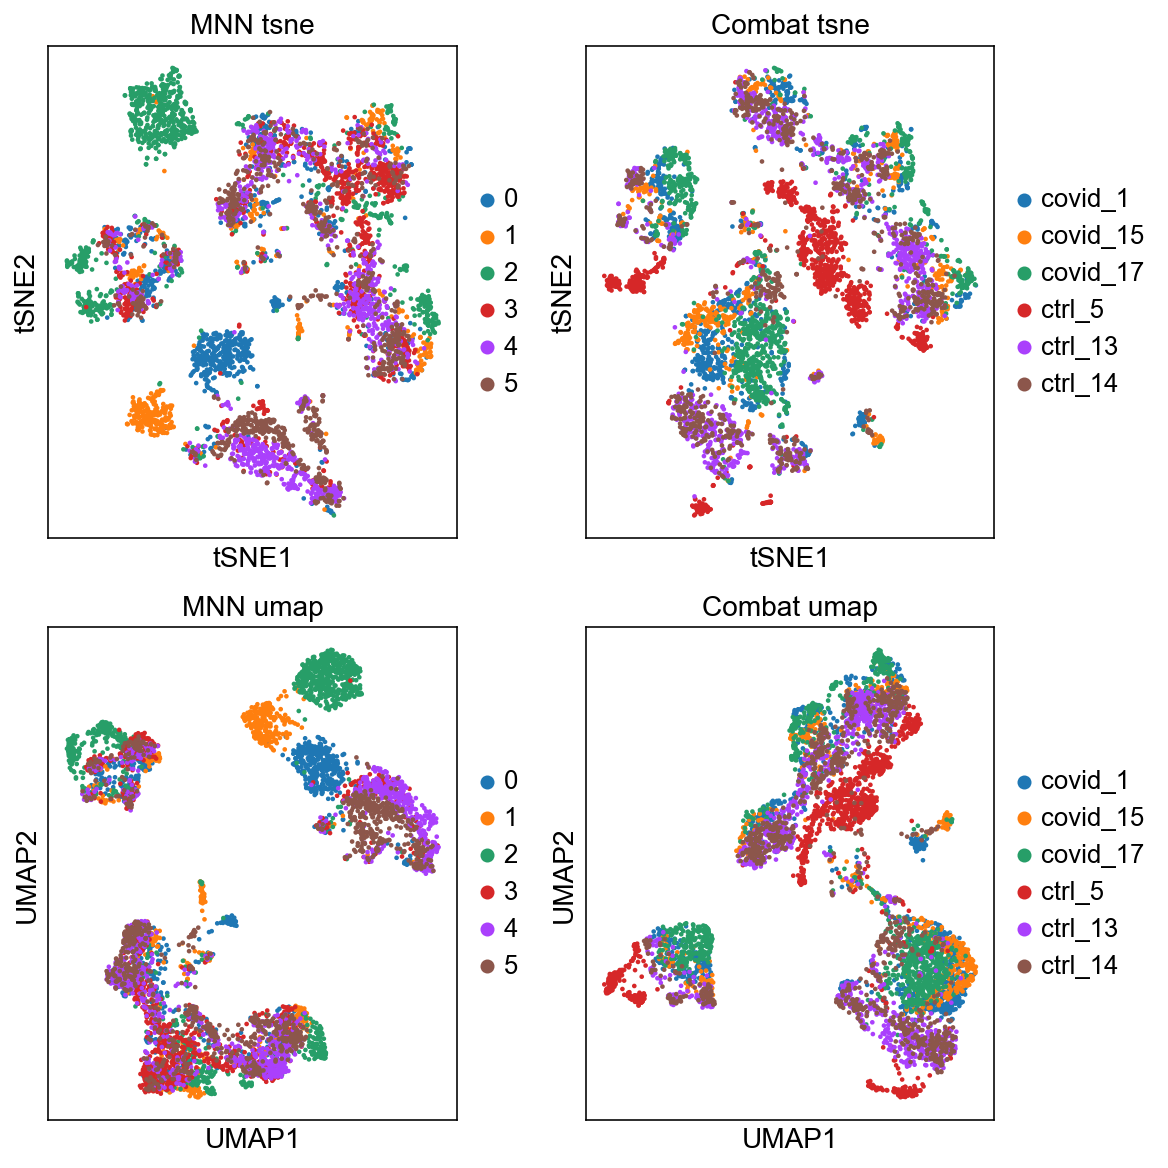

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="sample", title="MNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="sample", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="sample", title="MNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,1], show=False)


In [19]:
#save to file
save_file = './data/results/scanpy_combat_corrected_covid.h5ad'
adata_combat.write_h5ad(save_file)

###Scanorama

Try out [Scanorama](https://github.com/brianhie/scanorama) for data integration as well. 
To run Scanorama, you need to install python-annoy (already included in conda environment) and scanorama with pip. 
We can run scanorama to get a corrected matrix with the `correct` function, or to just get the data projected onto a new common dimension with the function `integrate`. Or both with the `correct_scanpy` and setting `return_dimred=True`. For now, run with just integration.


In [20]:
import scanorama


#subset the individual dataset to the same variable genes as in MNN-correct.
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)


covid_1
covid_15
covid_17
ctrl_5
ctrl_13
ctrl_14
Found 2720 genes among all datasets
[[0.         0.77491409 0.33754864 0.58830409 0.46900585 0.36959064]
 [0.         0.         0.5532646  0.5093412  0.31786942 0.35910653]
 [0.         0.         0.         0.37168142 0.08754864 0.1692607 ]
 [0.         0.         0.         0.         0.86627335 0.76106195]
 [0.         0.         0.         0.         0.         0.85323887]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (3, 4)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (3, 5)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 4)
Processing datasets (2, 3)
Processing datasets (0, 5)
Processing datasets (1, 5)
Processing datasets (0, 2)
Processing datasets (1, 4)
Processing datasets (2, 5)


In [21]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.

adatas[0].obsm['X_scanorama'].shape

(855, 50)

In [22]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
adata.obsm["Scanorama"] = all_s

(5594, 50)


In [23]:
# tsne and umap
sc.pp.neighbors(adata, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = 50, use_rep = "Scanorama")


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:37)


<AxesSubplot:title={'center':'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

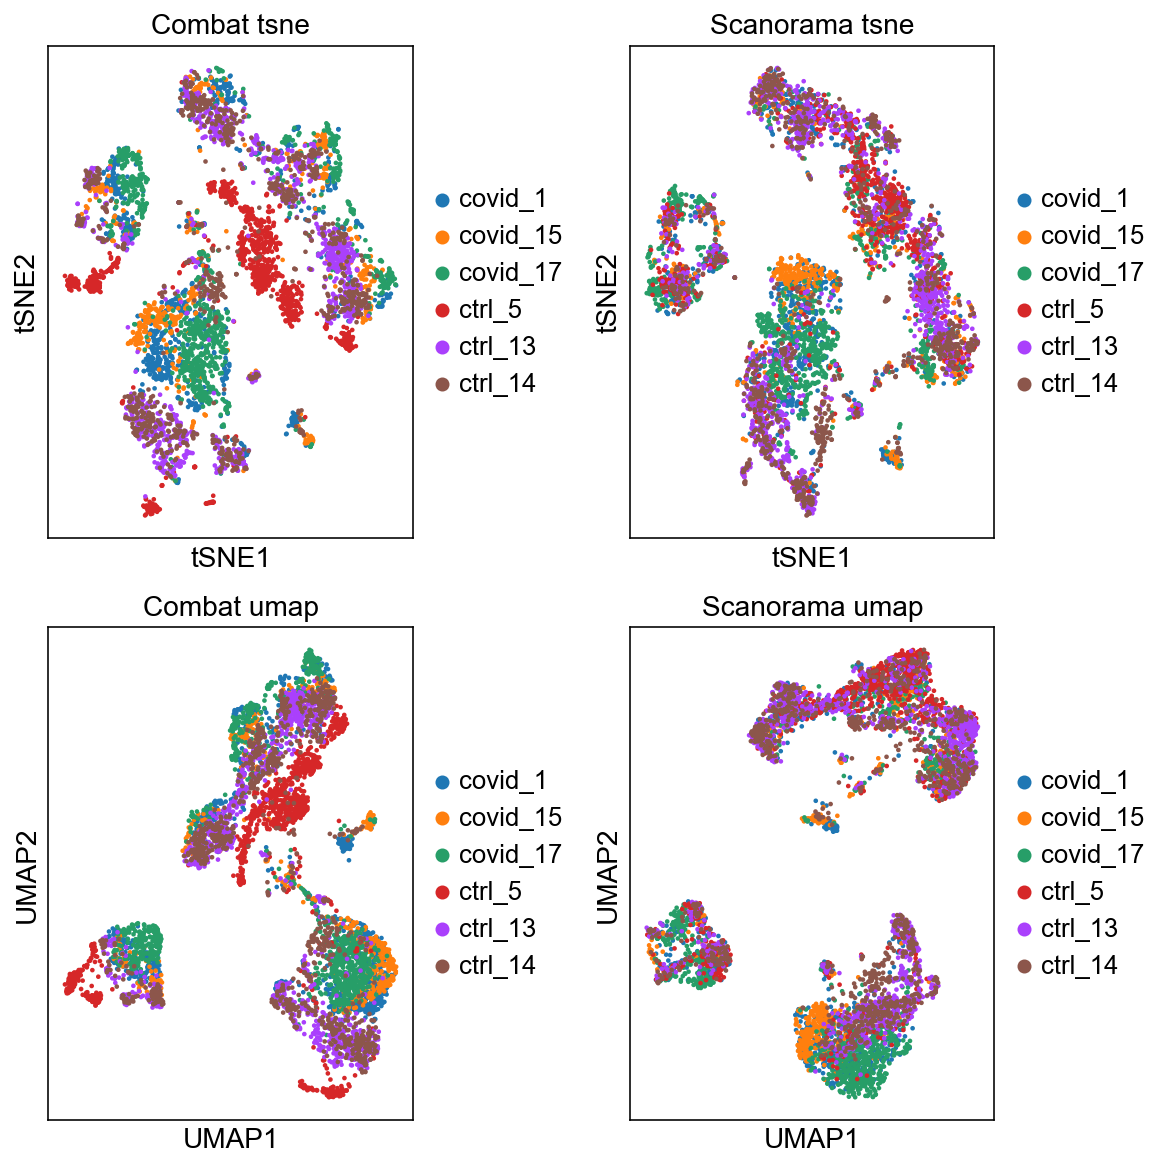

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(adata_combat, color="sample", title="Combat tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Scanorama tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)


In [25]:
#save to file
save_file = './data/results/scanpy_scanorama_corrected_covid.h5ad'
adata.write_h5ad(save_file)